# Intro


Recurrent Neural Networks (RNNs) are one of the simplest neural architectures designed to work with time series data. Conceptually, they form the foundation for more advanced sequence models such as LSTMs, GRUs, and, historically, even ideas that later influenced Transformers.

The core idea is straightforward: we feed a time series into a neural network **step by step**, where each step corresponds to one point in time.

At time step `t`, the model receives an input vector `x_t` and produces a prediction `ŷ_{t+1}` for the next time step. We then compare this prediction with the true next value `x_{t+1}` using a loss function, typically:

$$ MSE(ŷ_{t+1}, x_{t+1}) $$


This loss is minimized via gradient descent by iterating over the sequence. As a result, the model learns a neural network that approximates the **unknown underlying function** generating the time series.

Importantly, a time series can be seen as a function whose analytical form is unknown. The neural network — through its weights and biases — becomes a flexible parametric approximation of that function. In this sense, training an RNN is equivalent to fitting a highly non-linear function with learned curvature (weights) and offsets (biases) directly from data.

This notebook focuses on building and understanding this mechanism from first principles, before moving on to more complex sequence models.


# Input

`m_input` is simply the count of features we feed into the model; we can think of it as the number of columns in tabular data.

`n_output` is a data-irrelevant hyperparameter that defines the complexity of the network. The more neurons (the higher `n_output`), the more parameters our approximation function has, i.e. the more expressive or “curvy” it can be. Therefore, it is a direct neural network design parameter rather than a data parameter.

`HIST` is the history length of our data. If `HIST = 30`, this means we provide the model with 30 historical time steps, where each time step contains `m_input` features. Equivalently, this can be seen as the number of rows in tabular data when each row corresponds to a different time point (e.g. a day).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy

# net external nodes
m_input  = 32 # x_t
n_output = 12 # y_t

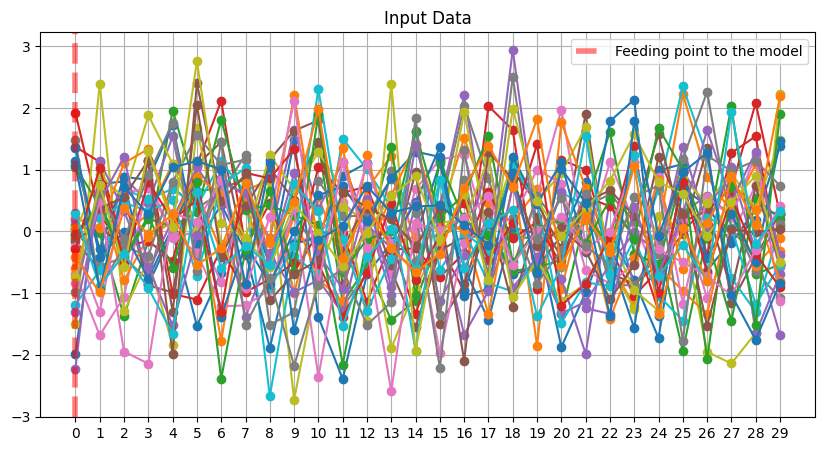

In [ ]:
# initialize random data
HIST = 30
x = np.random.randn(HIST, m_input)
plt.figure(figsize= (10,5))

plt.plot(x, '-o',)
plt.title('Input Data')
plt.axvline(0, label = 'Feeding point to the model', linewidth = 4, alpha = .5, color = 'r', linestyle = '--')
plt.legend()
plt.xticks(range(HIST))
plt.grid()
plt.show()

RNN is pretty straightforward: we take `x_t`, which has shape (`m_input`, 1), and produce `y_t`, which is the latent state. The latent state itself is not a prediction. To obtain a prediction of the next input, we introduce a readout mapping from the latent space to the input space.

The prediction is computed as

$$
\hat{x}_{t+1} = g(y_t) = W_{\text{out}}\, y_t + b_{\text{out}}
$$

where `W_out` maps the latent state to the input dimension and `b_out` is a bias term. This readout layer converts the information stored in `y_t` into an explicit prediction of the next data point.

We then define the loss as

$$
\text{Loss}_{\text{MSE}}(x_{t+1}, \hat{x}_{t+1})
$$

which we minimize to adjust the network parameters so that predictions match the actual data.

The more `T` we have, the more data we have to train our neural network. The last data point `x_{T-1}` is the final real input fed into the network and is used to generate the first prediction. After that, each subsequent prediction `\hat{x}` becomes the next input to the network in a free-running (autoregressive) mode.


# Hidden State Evolution

## Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy

## State and Params

In [ ]:
# initialize random y_0
y = np.random.randn(n_output)
# initialize random w_0
W = np.random.randn(n_output, m_input + n_output)
# initialize random b_0
b = np.ones((n_output))
# initialize pred buffer
Y = np.zeros((1, n_output))
Y[0] = y

Random latent space neurons $y$ of shape (`n_output`)

In [ ]:
y, y.shape

(array([-0.34807302, -0.54587674, -0.00783801,  0.9779513 ,  1.06961569,
         0.42617865,  0.39872657, -0.83987532,  0.59430948,  1.49675775,
        -1.18100612,  0.13285124]),
 (12,))

Random weight $W$ of shape (`n_output`, `m_input` + `n_output`)

In [ ]:
W.shape

(12, 44)

Bias vector from ones of shape (`m_input` + `n_output`)

In [ ]:
b, b.shape

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), (12,))

Y is a buffer, we safe all latent neurons for all $y_t$ in here. At the beggining Y has shape of (1, `n_output`) to reach eventually shape of (T, `n_output`)

In [ ]:
Y, Y.shape

(array([[-0.34807302, -0.54587674, -0.00783801,  0.9779513 ,  1.06961569,
          0.42617865,  0.39872657, -0.83987532,  0.59430948,  1.49675775,
         -1.18100612,  0.13285124]]),
 (1, 12))

##Ablation on Random Data

The latent vector `y` is introduced to act as memory. Recall that at each time step the network receives a concatenated input:

$$
z = \text{cat}(x_t, y_{t-1})
$$

and produces a new latent state:

$$
\widehat{y}_t = \text{net}(z)
$$

In other words, the model receives all data features from time `t` together with the latent vector from time `t-1`, which is supposed to carry information about the past.

Intuitively, this means that the latent vector `y` should encode temporal structure — if such structure exists in the data. The latent state does not *create* memory by itself; it can only store information that is actually present across time.

This leads to a simple and important sanity check.

If the data is randomly generated and has no temporal dependence (i.e. no memory), then using a latent state should not help. In that case, the following two setups should behave essentially the same:

$$
z = x_t
$$

and

$$
z = \text{cat}(x_t, y_{t-1})
$$

because there is no meaningful information to carry over from the past. The latent vector has nothing to memorize.

Later on, we will perform the same ablation on real stock market data. If temporal structure exists, the behavior with and without the latent state should differ significantly. This experiment allows us to empirically verify whether the data actually contains memory that the model can exploit.


### Memory Latent State Rollout

$ z $ is given by concatenating $x$ with $y$, only after we do:

$$ s = W \cdot z $$

That means we feed past and future (at first random future) to the model.

In [ ]:
import torch.nn as nn
import torch
from torch import optim

In [ ]:
# initialize random y_0
y = np.random.randn(n_output)
# initialize random w_0
W = np.random.randn(n_output, m_input + n_output)
# initialize random b_0
b = np.ones((m_input + n_output))
# initialize pred buffer
Y = np.zeros((1, n_output))
Y[0] = y

print('x shape:', x.shape)
print('y shape:', y.shape)

# squashing function
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

PRED_SCOPE = 20

for t in range(HIST):

  # concatenate subsequent y_t with input x
  x_curr = x[t]
  z = np.concatenate((x_curr, y), axis = 0)

  # w_kl and z_l product
  s = W @ z

  # y_hid is given by squashing function from s
  y_hid = sigmoid(s)

  # store laten space y_p in buffer Y
  Y = np.vstack((Y, y_hid))
  y = copy.deepcopy(y_hid)
  print('t:',t,'Rollout shape:', Y.shape)

x shape: (30, 32)
y shape: (12,)
t: 0 Rollout shape: (2, 12)
t: 1 Rollout shape: (3, 12)
t: 2 Rollout shape: (4, 12)
t: 3 Rollout shape: (5, 12)
t: 4 Rollout shape: (6, 12)
t: 5 Rollout shape: (7, 12)
t: 6 Rollout shape: (8, 12)
t: 7 Rollout shape: (9, 12)
t: 8 Rollout shape: (10, 12)
t: 9 Rollout shape: (11, 12)
t: 10 Rollout shape: (12, 12)
t: 11 Rollout shape: (13, 12)
t: 12 Rollout shape: (14, 12)
t: 13 Rollout shape: (15, 12)
t: 14 Rollout shape: (16, 12)
t: 15 Rollout shape: (17, 12)
t: 16 Rollout shape: (18, 12)
t: 17 Rollout shape: (19, 12)
t: 18 Rollout shape: (20, 12)
t: 19 Rollout shape: (21, 12)
t: 20 Rollout shape: (22, 12)
t: 21 Rollout shape: (23, 12)
t: 22 Rollout shape: (24, 12)
t: 23 Rollout shape: (25, 12)
t: 24 Rollout shape: (26, 12)
t: 25 Rollout shape: (27, 12)
t: 26 Rollout shape: (28, 12)
t: 27 Rollout shape: (29, 12)
t: 28 Rollout shape: (30, 12)
t: 29 Rollout shape: (31, 12)


Let's see state $Y$ buffer.

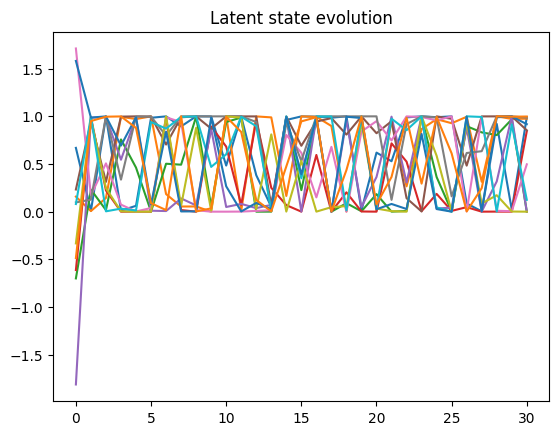

In [ ]:
plt.plot(Y)
plt.title('Latent state evolution')
plt.show()

Values remain within the range
(0,1), which is expected due to the use of the sigmoid activation function. The signal does not vanish over time, indicating that the model retains memory.

### No-Memory State Rollout

To see behaviour of model without memory we need to remove from $z$ prediction $y$, i.e.:

$$ z = x $$

We also need to change weights initialization into:

$$ W = (\text{n_output}, \text{m_input})$$

In [ ]:
# initialize random y_0
y = np.random.randn(n_output)
# initialize random w_0
W = np.random.randn(n_output, m_input)
# initialize random b_0
b = np.ones((m_input + n_output))
# initialize pred buffer
Y = np.zeros((1, n_output))
Y[0] = y

print('x shape:', x.shape)
print('y shape:', y.shape)

# squashing function
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

PRED_SCOPE = 20

for t in range(HIST):

  # concatenate subsequent y_t with input x
  x_curr = x[t]
  # z = np.concatenate((x_curr, y), axis = 0)
  z = np.array(x_curr)

  # w_kl and z_l product
  s = W @ z

  # y_hid is given by squashing function from s
  y_hid = sigmoid(s)

  # store laten space y_p in buffer Y
  Y = np.vstack((Y, y_hid))
  y = copy.deepcopy(y_hid)
  print('t:',t,'Rollout shape:', Y.shape)

x shape: (30, 32)
y shape: (12,)
t: 0 Rollout shape: (2, 12)
t: 1 Rollout shape: (3, 12)
t: 2 Rollout shape: (4, 12)
t: 3 Rollout shape: (5, 12)
t: 4 Rollout shape: (6, 12)
t: 5 Rollout shape: (7, 12)
t: 6 Rollout shape: (8, 12)
t: 7 Rollout shape: (9, 12)
t: 8 Rollout shape: (10, 12)
t: 9 Rollout shape: (11, 12)
t: 10 Rollout shape: (12, 12)
t: 11 Rollout shape: (13, 12)
t: 12 Rollout shape: (14, 12)
t: 13 Rollout shape: (15, 12)
t: 14 Rollout shape: (16, 12)
t: 15 Rollout shape: (17, 12)
t: 16 Rollout shape: (18, 12)
t: 17 Rollout shape: (19, 12)
t: 18 Rollout shape: (20, 12)
t: 19 Rollout shape: (21, 12)
t: 20 Rollout shape: (22, 12)
t: 21 Rollout shape: (23, 12)
t: 22 Rollout shape: (24, 12)
t: 23 Rollout shape: (25, 12)
t: 24 Rollout shape: (26, 12)
t: 25 Rollout shape: (27, 12)
t: 26 Rollout shape: (28, 12)
t: 27 Rollout shape: (29, 12)
t: 28 Rollout shape: (30, 12)
t: 29 Rollout shape: (31, 12)


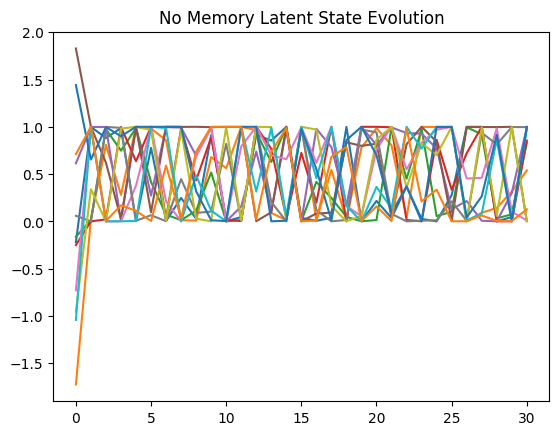

In [ ]:
plt.plot(Y)
plt.title('No Memory Latent State Evolution')
plt.show()

### Outcome

For randomly generated data, each time step is independent from the previous one:

$$
p(x_t \mid x_{t-1}) = p(x_t)
$$

This means the past carries no information about the future. There is nothing to memorize.

In this case, adding a latent state does not help. Using

$$
z = \text{cat}(x_t, y_{t-1})
$$

or simply

$$
z = x_t
$$

leads to nearly identical behavior, because the latent vector has no meaningful structure to store. The recurrent pathway receives no informative gradient signal and therefore does not encode meaningful temporal structure.

This is not a model failure. It is a direct consequence of the data having no temporal structure.


# PyTorch Implementation

## Model

In [ ]:
import torch
import torch.nn as nn

# ===== MODEL =====
class CreateNet(nn.Module):
    def __init__(self, m_input, n_hidden):
        super().__init__()
        self.n_hidden = n_hidden
        self.W = nn.Linear(m_input + n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden, m_input)

    def forward(self, x, h):
        z = torch.cat([x, h], dim=0)
        h = torch.sigmoid(self.W(z))
        x_hat = self.out(h)
        return x_hat, h

def CreateModel(m_input, n_hidden, lr=1e-3):
    net = CreateNet(m_input, n_hidden)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    return net, loss_fn, optimizer

## Training

In [ ]:
# ===== TRAINING =====
def ModelTrain(net, loss_fn, optimizer, x, epochs=200):
    T, m_input = x.shape

    losses = torch.zeros(epochs)

    for epoch in range(epochs):
        h = torch.zeros(net.n_hidden)
        loss_total = 0.0

        for t in range(T - 1):
            x_t = x[t]
            x_next = x[t + 1]

            x_hat, h = net(x_t, h)
            loss = loss_fn(x_hat, x_next)
            loss_total += loss

        losses[epoch] = loss_total
        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"epoch {epoch}, loss {loss_total.item():.4f}")

    return losses, net

## Usage

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

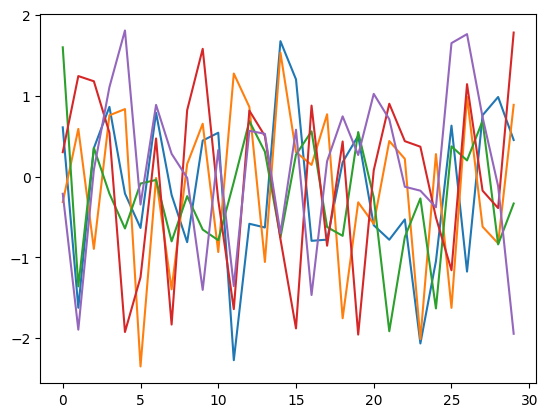

In [ ]:
T = 30
m_input = 5
n_hidden = 10

x = torch.randn(T, m_input)

plt.plot(x)
plt.show()

In [ ]:
net, loss_fn, optimizer = CreateModel(m_input, n_hidden)
losses, net = ModelTrain(net, loss_fn, optimizer, x, epochs=10000)

epoch 0, loss 30.7996
epoch 100, loss 26.3204
epoch 200, loss 25.5039
epoch 300, loss 24.4833
epoch 400, loss 23.3388
epoch 500, loss 22.1796
epoch 600, loss 20.8852
epoch 700, loss 19.2694
epoch 800, loss 17.5071
epoch 900, loss 15.9332
epoch 1000, loss 14.5948
epoch 1100, loss 13.4064
epoch 1200, loss 12.3081
epoch 1300, loss 11.2833
epoch 1400, loss 10.3438
epoch 1500, loss 9.4859
epoch 1600, loss 8.6789
epoch 1700, loss 7.8863
epoch 1800, loss 7.1027
epoch 1900, loss 6.3561
epoch 2000, loss 5.6657
epoch 2100, loss 5.0477
epoch 2200, loss 4.5129
epoch 2300, loss 4.0554
epoch 2400, loss 3.6599
epoch 2500, loss 3.3121
epoch 2600, loss 3.0050
epoch 2700, loss 2.7377
epoch 2800, loss 2.5065
epoch 2900, loss 2.3037
epoch 3000, loss 2.1238
epoch 3100, loss 1.9652
epoch 3200, loss 1.8271
epoch 3300, loss 1.7077
epoch 3400, loss 1.6038
epoch 3500, loss 1.5118
epoch 3600, loss 1.4287
epoch 3700, loss 1.3517
epoch 3800, loss 1.2787
epoch 3900, loss 1.2090
epoch 4000, loss 1.1431
epoch 4100, l

## Loss

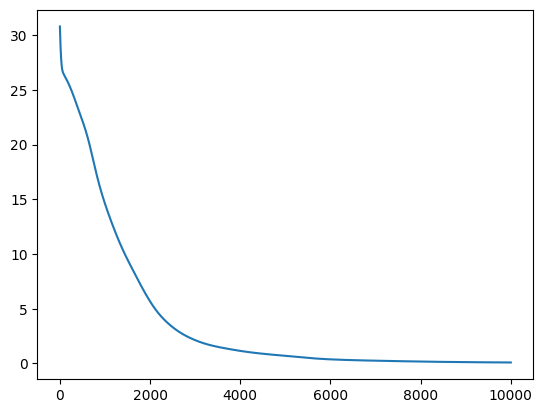

In [ ]:
plt.plot(losses.detach())

## Rollout

In [ ]:
def rollout(net, x, n_hidden, steps = 30):
  net.eval()
  with torch.no_grad():
    # store predictions with shape (steps, n_features)
    preds = torch.zeros(steps, x.shape[1])

    # first in is last datapoint from real data
    x_in = x[-1]

    # one latent space for whole net
    h = torch.zeros(net.n_hidden)

    # run
    for t in range(steps):

      # net output
      y_hat, h = net(x_in, h)

      # save pred
      preds[t] = y_hat

      # overwrite x_in
      x_in = y_hat

  return preds

In [ ]:
rollout = rollout(net, x, n_hidden, steps = 30)

## Plot

In [ ]:
def plot_history_with_rollout(x_history, x_rollout):
    T, m = x_history.shape
    H = x_rollout.shape[0]

    t_hist = range(T)
    t_roll = range(T - 1, T - 1 + H)

    plt.figure(figsize=(15, 8))

    for i in range(m):
        # historia
        line, = plt.plot(
            t_hist,
            x_history[:, i],
            alpha=0.8
        )
        color = line.get_color()

        # rollout — TEN SAM KOLOR
        plt.plot(
            t_roll,
            x_rollout[:, i],
            linestyle='--',
            linewidth=2,
            color=color
        )

    plt.axvline(
        T - 1,
        linestyle='--',
        color='black',
        linewidth=2,
        label='end of observed data'
    )

    plt.title('Time Series: Observed History vs Model Rollout')
    plt.xlabel('time')
    plt.ylabel('value')
    plt.grid(alpha=0.3)

    # ręczna legenda (żeby nie było śmietnika)
    plt.plot([], [], '-', color='gray', label='observed')
    plt.plot([], [], '--', color='gray', label='rollout')
    plt.legend()

    plt.show()


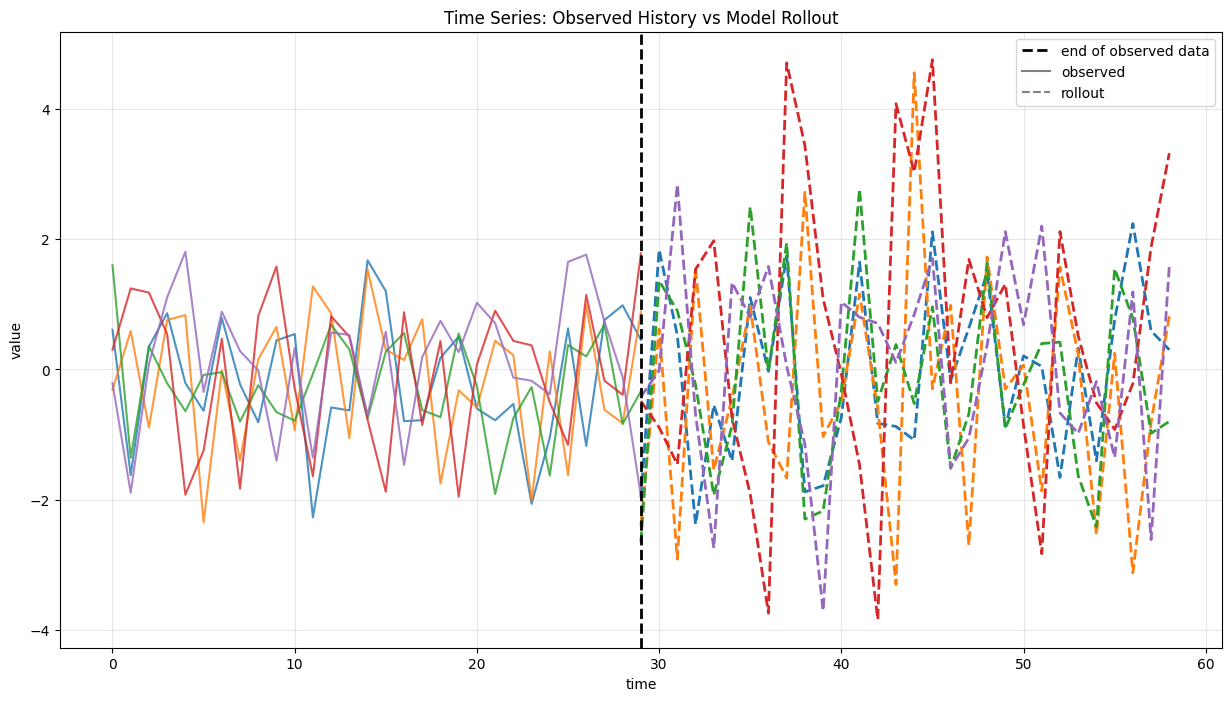

In [ ]:
plot_history_with_rollout(x, rollout)

## Ablation on Stock Data

### Data

We are going to take 5 financial time series which are dependent.  
By dependent I do not mean a strict mathematical dependency — I did not compute correlations here —  but rather an economic and rational one.

We can reasonably assume that these 5 indices are correlated with each other due to shared market dynamics.

What we want to test is the following:

If we remove the hidden state from `z`, will the model behave any differently compared to the model where  
`z` contains both the current input `x_t` and the previous latent state `y_{t-1}`?

In other words, we compare:
- a **memory-less model**, where `z = x_t`
- a **memory-based model**, where `z = cat(x_t, y_{t-1})`

This experiment will show whether the latent state actually captures useful temporal structure  
in data that is assumed to have real-world memory.

Just here we will count predictions as well just to see how good is it.


/tmp/ipython-input-2995890861.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start="2010-01-01", end="2025-01-01", progress=False)
/tmp/ipython-input-2995890861.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start="2010-01-01", end="2025-01-01", progress=False)
/tmp/ipython-input-2995890861.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start="2010-01-01", end="2025-01-01", progress=False)
/tmp/ipython-input-2995890861.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start="2010-01-01", end="2025-01-01", progress=False)
/tmp/ipython-input-2995890861.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start="2010-01-01", end="2025-01-01", progress=False)


Raw data shape: (3768, 5)
Final shape (HIST, m_input): (30, 5)


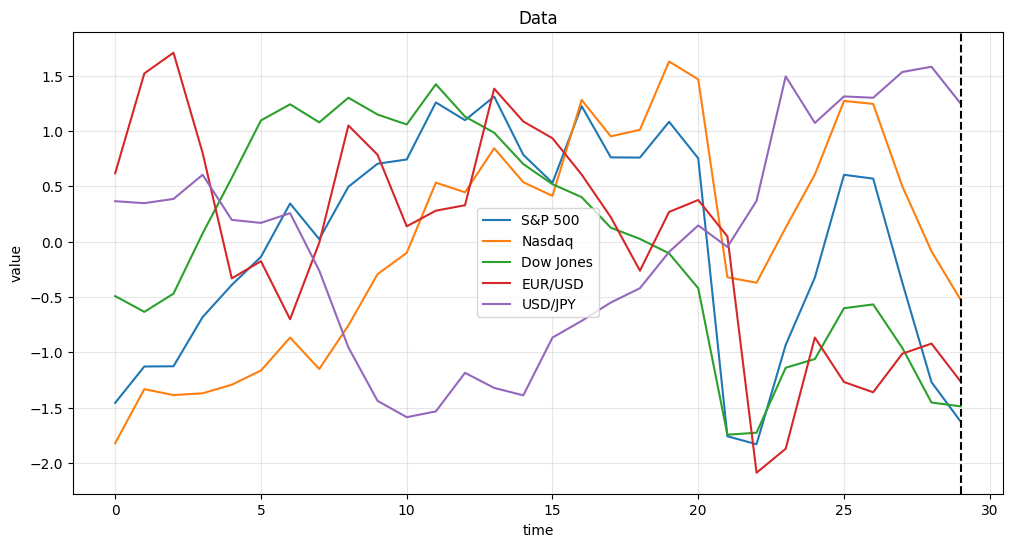

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tickers = [
    "^GSPC",     # S&P 500
    "^IXIC",     # Nasdaq
    "^DJI",      # Dow Jones
    "EURUSD=X",  # EUR/USD
    "USDJPY=X"   # USD/JPY
]

labels = [
    'S&P 500',
    'Nasdaq',
    'Dow Jones',
    'EUR/USD',
    'USD/JPY'
]

series = []

for t in tickers:
    df = yf.download(t, start="2010-01-01", end="2025-01-01", progress=False)
    series.append(df["Close"])

data = pd.concat(series, axis=1).dropna()

print("Raw data shape:", data.shape)

HIST = 30
x_raw = data.tail(HIST)

# normalize per feature
x = (x_raw - x_raw.mean()) / x_raw.std()
x = x.values  # numpy for your RNN

print("Final shape (HIST, m_input):", x.shape)

plt.figure(figsize=(12, 6))
for i in range(x.shape[1]):
    plt.plot(x[:, i])
plt.axvline(x.shape[0]-1, linestyle="--", color="black", label="end of data")
plt.title("Data")
plt.xlabel("time")
plt.ylabel("value")
plt.grid(alpha=0.3)
plt.legend(labels)
plt.show()


### Model with Latent State

In [ ]:
import torch
import torch.nn as nn

# ===== MODEL =====
class CreateNet(nn.Module):
    def __init__(self, m_input, n_hidden):
        super().__init__()
        self.n_hidden = n_hidden
        self.W = nn.Linear(m_input + n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden, m_input)

    def forward(self, x, h):
        z = torch.cat([x, h], dim=0)
        h = torch.sigmoid(self.W(z))
        x_hat = self.out(h)
        return x_hat, h

def CreateModel(m_input, n_hidden, lr=1e-3):
    net = CreateNet(m_input, n_hidden)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    return net, loss_fn, optimizer

In [ ]:
net, loss_fn, optimizer = CreateModel(m_input = 5, n_hidden = n_hidden, lr = 1e-3)

#### Model Train

In [ ]:
# ===== TRAINING =====
def ModelTrain(net, loss_fn, optimizer, x, epochs=200):
    T, m_input = x.shape

    losses = torch.zeros(epochs)
    H_history = []

    for epoch in range(epochs):
        h = torch.zeros(net.n_hidden)
        loss_total = 0.0
        h_epoch = []

        for t in range(T - 1):
            x_t = x[t]
            x_next = x[t + 1]

            x_hat, h = net(x_t, h)
            loss = loss_fn(x_hat, x_next)

            loss_total += loss
            h_epoch.append(h.detach())

        losses[epoch] = loss_total.detach()
        H_history.append(torch.stack(h_epoch))

        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"epoch {epoch}, loss {loss_total.item():.4f}")

    return losses, net, H_history


In [ ]:
x = torch.tensor(x, dtype=torch.float32)

In [ ]:
losses_memo, net_memo, h_history_memo = ModelTrain(net, loss_fn, optimizer, x, epochs=5000)

epoch 0, loss 30.4375
epoch 100, loss 24.1053
epoch 200, loss 15.8550
epoch 300, loss 10.4426
epoch 400, loss 8.0638
epoch 500, loss 7.0786
epoch 600, loss 6.5104
epoch 700, loss 6.0321
epoch 800, loss 5.5541
epoch 900, loss 5.0622
epoch 1000, loss 4.6076
epoch 1100, loss 4.2266
epoch 1200, loss 3.8944
epoch 1300, loss 3.5924
epoch 1400, loss 3.3120
epoch 1500, loss 3.0413
epoch 1600, loss 2.7710
epoch 1700, loss 2.5085
epoch 1800, loss 2.2665
epoch 1900, loss 2.0542
epoch 2000, loss 1.8756
epoch 2100, loss 1.7291
epoch 2200, loss 1.6085
epoch 2300, loss 1.5062
epoch 2400, loss 1.4157
epoch 2500, loss 1.3323
epoch 2600, loss 1.2528
epoch 2700, loss 1.1755
epoch 2800, loss 1.0994
epoch 2900, loss 1.0241
epoch 3000, loss 0.9494
epoch 3100, loss 0.8760
epoch 3200, loss 0.8059
epoch 3300, loss 0.7416
epoch 3400, loss 0.6842
epoch 3500, loss 0.6337
epoch 3600, loss 0.5893
epoch 3700, loss 0.5502
epoch 3800, loss 0.5159
epoch 3900, loss 0.4856
epoch 4000, loss 0.4587
epoch 4100, loss 0.4346


### Model without Latent State

In [ ]:
import torch
import torch.nn as nn

# ===== MODEL =====
class CreateNet(nn.Module):
    def __init__(self, m_input, n_hidden):
        super().__init__()
        self.n_hidden = n_hidden
        self.W = nn.Linear(m_input, n_hidden)
        self.out = nn.Linear(n_hidden, m_input)

    def forward(self, x):
        z = torch.cat([x], dim=0)
        h = torch.sigmoid(self.W(z))
        x_hat = self.out(h)
        return x_hat, h

def CreateModel(m_input, n_hidden, lr=1e-3):
    net = CreateNet(m_input, n_hidden)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    return net, loss_fn, optimizer

In [ ]:
net, loss_fn, optimizer = CreateModel(m_input = 5, n_hidden = n_hidden, lr = 1e-3)

#### Model Train

In [ ]:
# ===== TRAINING =====
def ModelTrain(net, loss_fn, optimizer, x, epochs=200):
    T, m_input = x.shape

    losses = torch.zeros(epochs)
    H_history = []

    for epoch in range(epochs):
        h = torch.zeros(net.n_hidden)
        loss_total = 0.0
        h_epoch = []

        for t in range(T - 1):
            x_t = x[t]
            x_next = x[t + 1]

            x_hat, h = net(x_t)
            loss = loss_fn(x_hat, x_next)

            loss_total += loss
            h_epoch.append(h.detach())

        losses[epoch] = loss_total.detach()
        H_history.append(torch.stack(h_epoch))

        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"epoch {epoch}, loss {loss_total.item():.4f}")

    return losses, net, H_history


In [ ]:
losses_nomemo, net_nomemo, h_history_nomemo = ModelTrain(net, loss_fn, optimizer, x, epochs=5000)

epoch 0, loss 37.1519
epoch 100, loss 25.2495
epoch 200, loss 18.9461
epoch 300, loss 13.6837
epoch 400, loss 10.4980
epoch 500, loss 8.7069
epoch 600, loss 7.6894
epoch 700, loss 7.1058
epoch 800, loss 6.7331
epoch 900, loss 6.4465
epoch 1000, loss 6.2003
epoch 1100, loss 5.9888
epoch 1200, loss 5.8144
epoch 1300, loss 5.6758
epoch 1400, loss 5.5664
epoch 1500, loss 5.4773
epoch 1600, loss 5.4001
epoch 1700, loss 5.3283
epoch 1800, loss 5.2568
epoch 1900, loss 5.1815
epoch 2000, loss 5.0992
epoch 2100, loss 5.0070
epoch 2200, loss 4.9039
epoch 2300, loss 4.7914
epoch 2400, loss 4.6735
epoch 2500, loss 4.5551
epoch 2600, loss 4.4404
epoch 2700, loss 4.3313
epoch 2800, loss 4.2279
epoch 2900, loss 4.1293
epoch 3000, loss 4.0341
epoch 3100, loss 3.9411
epoch 3200, loss 3.8488
epoch 3300, loss 3.7561
epoch 3400, loss 3.6616
epoch 3500, loss 3.5640
epoch 3600, loss 3.4626
epoch 3700, loss 3.3569
epoch 3800, loss 3.2478
epoch 3900, loss 3.1366
epoch 4000, loss 3.0245
epoch 4100, loss 2.9123

### Comparison Memo with No-Memo

#### Loss and Hidden states

In [ ]:
import matplotlib.pyplot as plt
import torch

def plot_loss_and_hidden(
    losses_memo,
    losses_nomemo,
    h_history_memo,
    h_history_nomemo
):
    """
    2x2:
    [ loss memo     | loss no-memo ]
    [ h memo        | h no-memo    ]
    """

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # ===== LOSS =====
    axes[0, 0].plot(losses_memo.detach())
    axes[0, 0].set_title("Training Loss (with memory)")
    axes[0, 0].set_xlabel("epoch")
    axes[0, 0].set_ylabel("loss")
    axes[0, 0].grid(alpha=0.3)

    axes[0, 1].plot(losses_nomemo.detach())
    axes[0, 1].set_title("Training Loss (no memory)")
    axes[0, 1].set_xlabel("epoch")
    axes[0, 1].set_ylabel("loss")
    axes[0, 1].grid(alpha=0.3)

    # ===== HIDDEN STATE (ostatnia epoka) =====
    H_memo = h_history_memo[-1].detach().numpy()
    H_nomemo = h_history_nomemo[-1].detach().numpy()

    axes[1, 0].plot(H_memo)
    axes[1, 0].set_title("Hidden state evolution (with memory)")
    axes[1, 0].set_xlabel("time")
    axes[1, 0].set_ylabel("value")
    axes[1, 0].grid(alpha=0.3)

    axes[1, 1].plot(H_nomemo)
    axes[1, 1].set_title("Hidden state evolution (no memory)")
    axes[1, 1].set_xlabel("time")
    axes[1, 1].set_ylabel("value")
    axes[1, 1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_rollout_comparison(
    x_history,
    rollout_memo,
    rollout_nomemo
):
    """
    1x2:
    [ rollout memo | rollout no-memo ]
    """

    T, m = x_history.shape
    H = rollout_memo.shape[0]

    t_hist = range(T)
    t_roll = range(T - 1, T - 1 + H)

    fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    for ax, rollout, title in zip(
        axes,
        [rollout_memo, rollout_nomemo],
        ["Rollout WITH memory", "Rollout NO memory"]
    ):
        for i in range(m):
            line, = ax.plot(
                t_hist,
                x_history[:, i],
                alpha=0.8
            )
            color = line.get_color()

            ax.plot(
                t_roll,
                rollout[:, i],
                linestyle="--",
                linewidth=2,
                color=color
            )

        ax.axvline(
            T - 1,
            linestyle="--",
            color="black",
            linewidth=2
        )

        ax.set_title(title)
        ax.set_xlabel("time")
        ax.grid(alpha=0.3)

    axes[0].set_ylabel("value")

    # ręczna legenda
    axes[0].plot([], [], "-", color="gray", label="observed")
    axes[0].plot([], [], "--", color="gray", label="rollout")
    axes[0].legend()

    plt.tight_layout()
    plt.show()


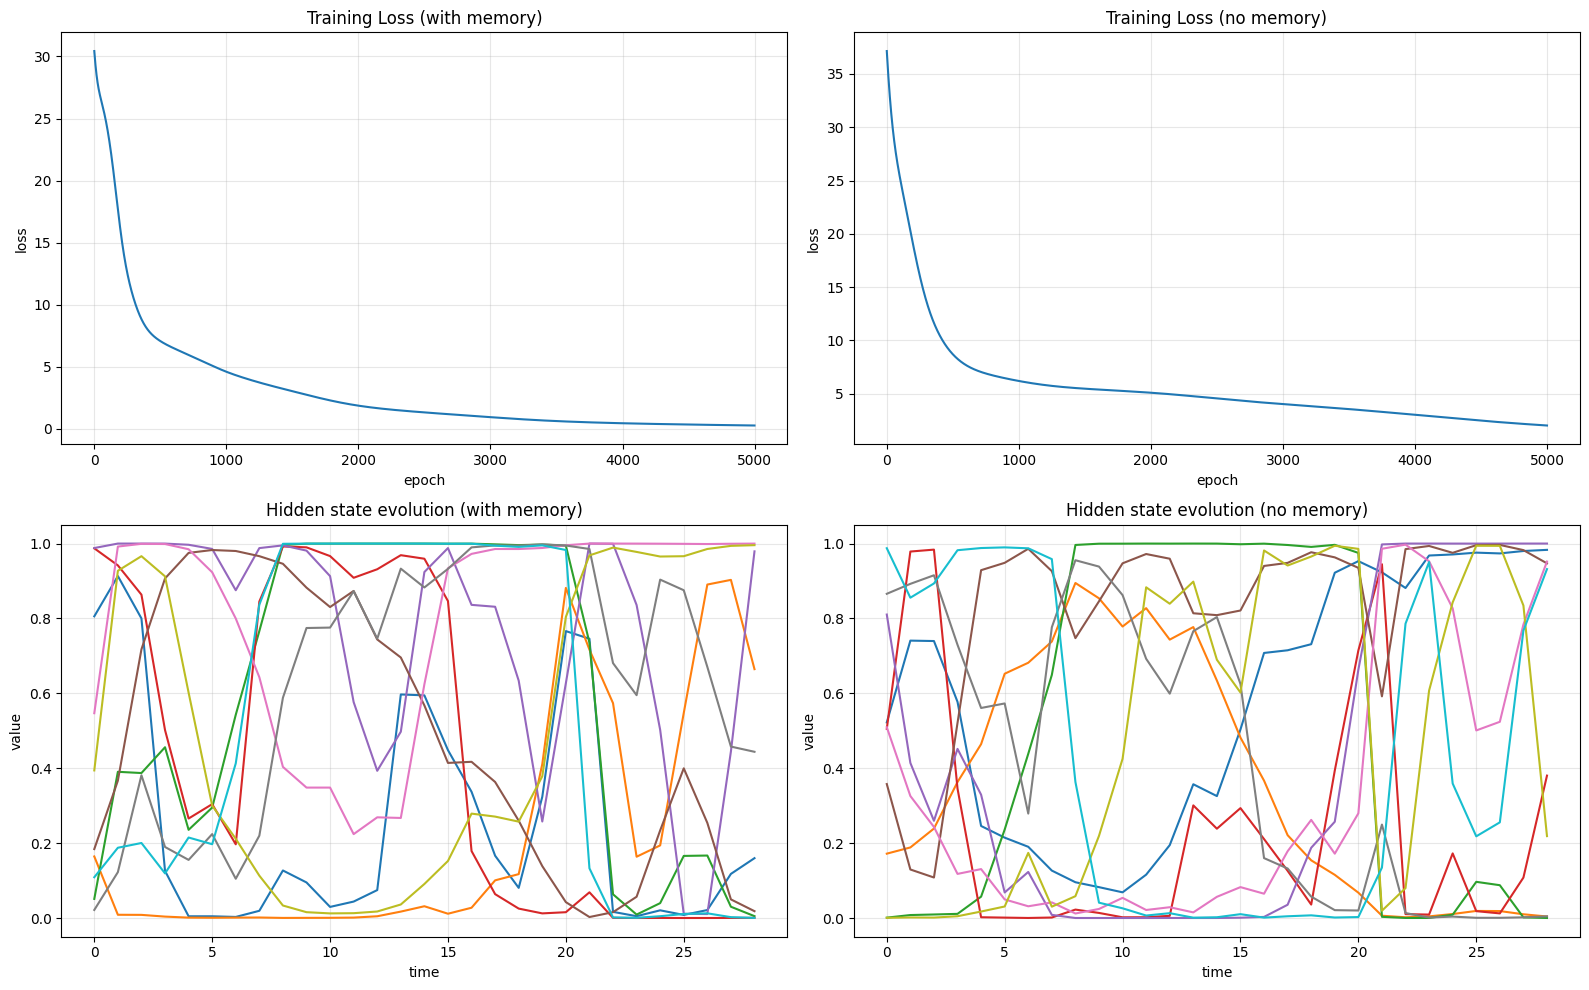

In [ ]:
# 1) LOSS + HIDDEN
plot_loss_and_hidden(
    losses_memo,
    losses_nomemo,
    h_history_memo,
    h_history_nomemo
)



From the plots we can clearly see the difference between a model with memory and a model without memory.

In the memory-based model, the hidden state remains active over time. Different latent dimensions activate at different moments, which means the hidden state carries information forward and acts as a true memory.

In the no-memory model, the hidden state gradually collapses. Many latent units saturate near 0 or 1, and the overall dynamics fade away. This happens because the hidden state is not fed back into the next step, so the model has no incentive to preserve information over time.

This demonstrates that a latent vector becomes memory only when it is used recurrently. Without feedback from the previous hidden state, the optimal solution is to eliminate temporal dynamics, leading to state collapse.


#### Rollouts

In [ ]:
def rollout_memo(net, x, n_hidden, steps = 30):
  net.eval()
  with torch.no_grad():
    # store predictions with shape (steps, n_features)
    preds = torch.zeros(steps, x.shape[1])
    # first in is last datapoint from real data
    x_in = x[-1]

    # one latent space for whole net
    h = torch.zeros(net.n_hidden)

    # run
    for t in range(steps):

      # net output
      y_hat, h = net(x_in, h)

      # save pred
      preds[t] = y_hat

      # overwrite x_in
      x_in = y_hat

  return preds

def rollout_nomemo(net, x, steps = 30):
  net.eval()
  with torch.no_grad():
    # store predictions with shape (steps, n_features)
    preds = torch.zeros(steps, x.shape[1])
    # first in is last datapoint from real data
    x_in = x[-1]

    # run
    for t in range(steps):

      # net output
      y_hat, h = net(x_in)

      # save pred
      preds[t] = y_hat

      # overwrite x_in
      x_in = y_hat

  return preds

In [ ]:
x_torch = torch.tensor(x, dtype=torch.float32)

preds_memo = rollout_memo(net_memo, x_torch, n_hidden = 5, steps=30)
preds_nomemo = rollout_nomemo(net_nomemo, x_torch, steps=30)

/tmp/ipython-input-1356927891.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_torch = torch.tensor(x, dtype=torch.float32)


In [ ]:
import matplotlib.pyplot as plt

def plot_history_with_rollout_compare(x_history, preds_memo, preds_nomemo):
    T, m = x_history.shape
    H = preds_memo.shape[0]

    t_hist = range(T)
    t_roll = range(T - 1, T - 1 + H)

    fig, axes = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

    for ax, rollout, title in zip(
        axes,
        [preds_memo, preds_nomemo],
        ["ROLL-OUT WITH MEMORY", "ROLL-OUT NO MEMORY"]
    ):
        for i in range(m):
            # history
            line, = ax.plot(
                t_hist,
                x_history[:, i],
                alpha=0.8
            )
            color = line.get_color()

            # rollout — SAME COLOR
            ax.plot(
                t_roll,
                rollout[:, i],
                linestyle='--',
                linewidth=2,
                color=color
            )

        ax.axvline(
            T - 1,
            linestyle='--',
            color='black',
            linewidth=2
        )

        ax.set_title(title)
        ax.set_ylabel("value")
        ax.grid(alpha=0.3)

    axes[-1].set_xlabel("time")

    # manual legend
    axes[0].plot([], [], '-', color='gray', label='observed')
    axes[0].plot([], [], '--', color='gray', label='rollout')
    axes[0].legend()

    plt.tight_layout()
    plt.show()


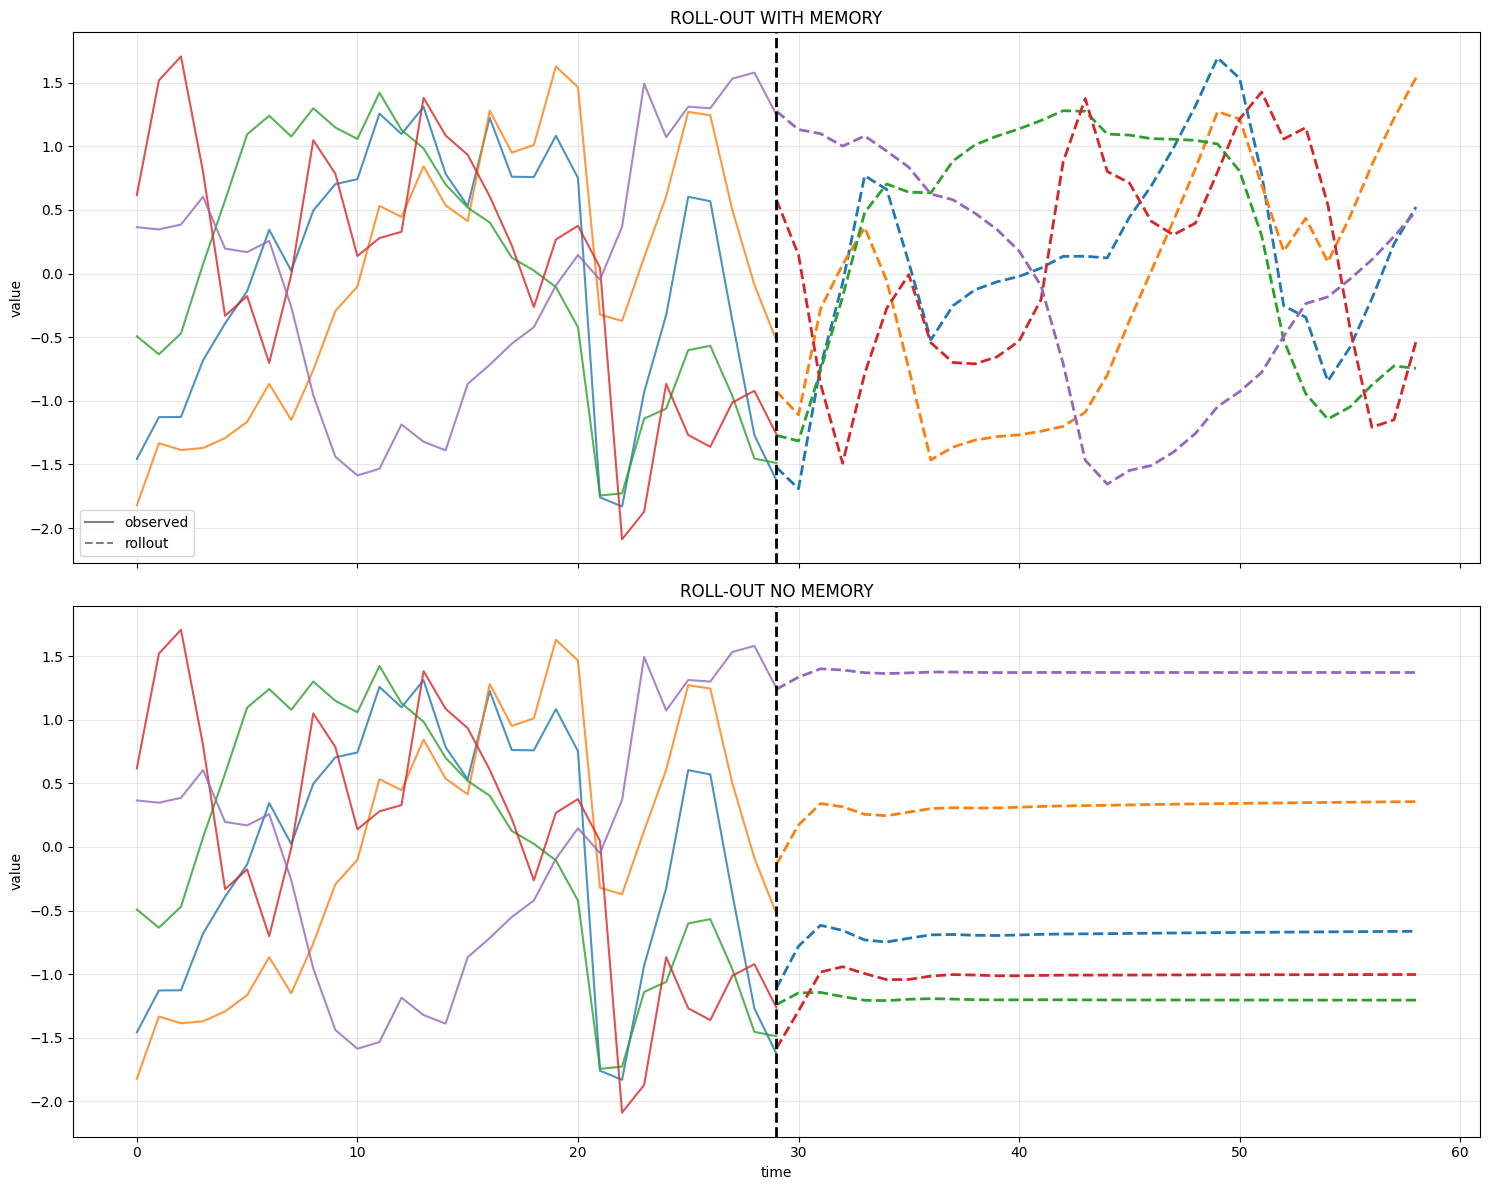

In [ ]:
plot_history_with_rollout_compare(
    x_history=x,
    preds_memo=preds_memo,
    preds_nomemo=preds_nomemo
)


This plot shows the key difference between a recurrent model with memory and a model without memory.

In the model with memory, the rollout remains dynamic after the observed data ends. The predictions continue to evolve, oscillate, and interact across features. This means the hidden state successfully encodes temporal structure and propagates it forward in time.

In the no-memory model, the rollout quickly collapses to near-constant values. After a few steps, the predictions become flat and unresponsive. This happens because the model has no access to past latent information, so the only stable solution is a fixed point.

This clearly demonstrates that recurrence (feeding y_{t-1} into the next step) is what enables temporal reasoning. Without memory, the model cannot extrapolate dynamics — it can only regress to the mean.
